## PAW wavelet clustering

In [220]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [221]:
""" 
IMPORTS
"""
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import numpy as np
import pandas as pd
from one.api import ONE
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from scipy import stats
from kneed import KneeLocator
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import seaborn as sns

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

# Get my functions
from functions import idxs_from_files, plot_kde, GMM_neg_log_likelihood

one = ONE(mode='remote')

In [222]:
""" 
LOAD DATA AND PARAMETERS
"""
# LOAD DATA

data_path = prefix + 'representation_learning_variability/paper-individuality/data/design_matrices/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices)

wavelet_path = prefix + 'representation_learning_variability/paper-individuality/data/paw_wavelets/'
velocity = True

path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
super_session = np.load(path+'supersession_wavelets_paw09-11-2025')

In [237]:

paws = ['l_paw',  'r_paw']
var_init = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y', 
                'l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 'l_paw_x16.0', 'l_paw_x32.0',
                'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 'l_paw_y16.0', 'l_paw_y32.0',
                'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0', 'r_paw_x16.0', 'r_paw_x32.0',
                'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0', 'r_paw_y16.0', 'r_paw_y32.0']
var_interest = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y', 
                'l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 
                'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 
                'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0',
                'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0']

# Wavelet clustering

In [238]:
df = pd.DataFrame(super_session, columns=var_init)

In [247]:
use_vars = var_interest[4:]
use_data = np.array(df[var_interest])[:, 4:]
zscore = True
reduce = False

if zscore:
    data = np.array(stats.zscore(use_data, axis=0))
else:
    X_centered = use_data - np.mean(use_data, axis=0)
    data = np.array(use_data)

## Reduce dimensionality

In [206]:

    
n_components = np.shape(data)[1]
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
X_pca = pca.fit_transform(data)

<BarContainer object of 28 artists>

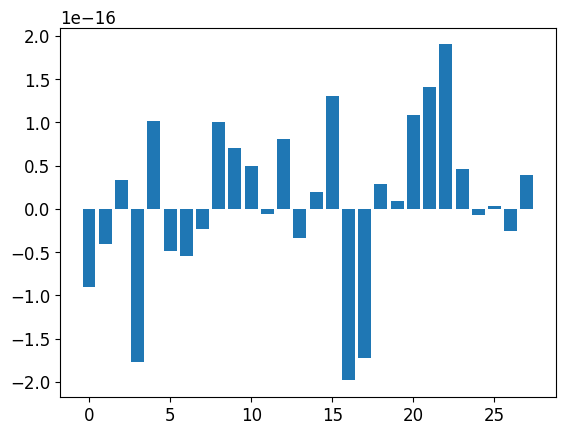

In [207]:
plt.bar(np.arange(0, n_components, 1), np.nanmean(stats.zscore(data, axis=0), axis=0))
# plt.bar(np.arange(0, 24, 1), np.nanmean(data, axis=0))
# plt.xlim([100, 200])

In [208]:
from sklearn.decomposition import PCA

n_components = np.shape(data)[1]
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
X_pca = pca.fit_transform(stats.zscore(data, axis=0))
# pca = PCA(n_components)  # Reduce to 50 dimensions
# X_pca = pca.fit_transform(data)

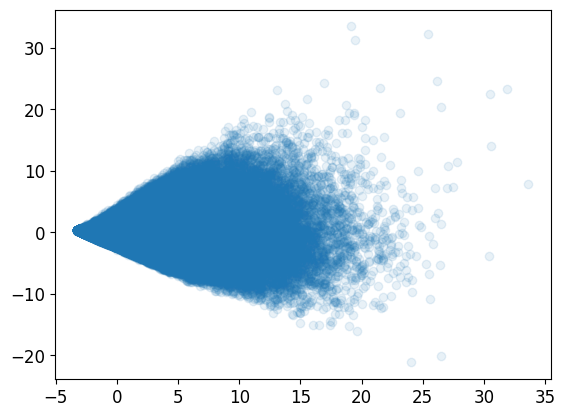

In [209]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=.1)

(0.0, 1.0)

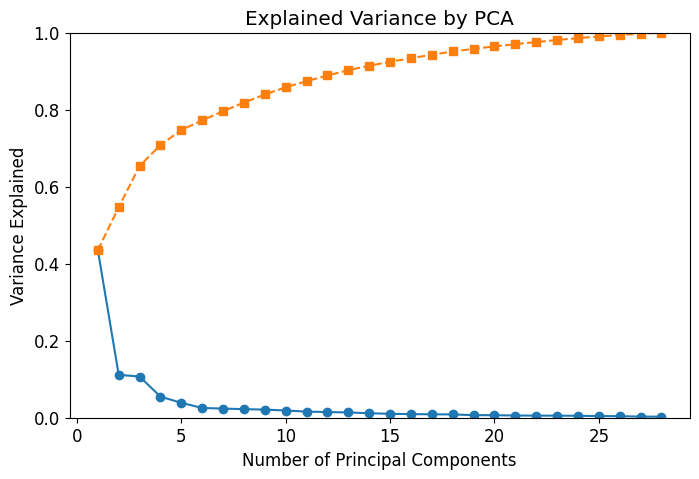

In [210]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")
plt.ylim([0, 1])

In [211]:
keep_components = np.min(np.where(cumulative_variance>0.89))
print(keep_components)

12


# Find best k

In [121]:
if reduce:
    use_data = X_pca[:, :keep_components].copy()
else:
    use_data = data.copy()

repeats = 1
components = np.array([1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
# components = np.array([1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 40, 60, 100, 500, 1000])
components = np.arange(1, 21, 1)
LLs = np.zeros((repeats, len(components))) * np.nan
for r in range(repeats):    
    # Compute log likelihood of a GMM model with different components
    LLs[r, :] = GMM_neg_log_likelihood(use_data.copy(), components)
kneedle = KneeLocator(components[1:], np.nanmean(LLs, axis=0)[1:], curve="convex", direction="decreasing")
kneedle = KneeLocator(components, np.nanmean(LLs, axis=0), curve="convex", direction="decreasing")
optimal_k = kneedle.knee

KeyboardInterrupt: 

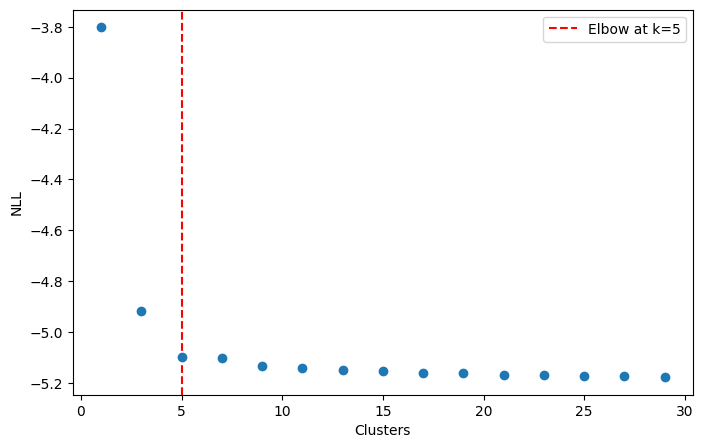

In [66]:
# Plot
fig, ax = plt.subplots(figsize=(8, 5))
# plt.plot(components[1:], LLs[0][1:], 'bo-', label="Model Fit")
plt.errorbar(components, np.nanmean(LLs, axis=0), np.nanstd(LLs, axis=0)/np.sqrt(repeats), linestyle='None', marker='o')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
plt.xlabel("Clusters")
plt.ylabel("NLL")
plt.legend()
plt.show()

In [122]:
if reduce:
    use_data = X_pca[:, :keep_components].copy()
else:
    use_data = data.copy()
inertia_values = []
K = range(1, 40)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cutoff = int(np.shape(use_data)[0]*0.8)
    X_train = np.vstack([use_data[:cutoff, 0], use_data[:cutoff, 1]]).T
    kmeans.fit(X_train)
    inertia_values.append(kmeans.inertia_)
    
kneedle = KneeLocator(K, inertia_values, curve="convex", direction="decreasing")
optimal_k = kneedle.knee
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
# Plotting the inertia values
plt.scatter(K, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.show()

KeyboardInterrupt: 

In [ ]:
print(optimal_k)

# kMeans on supersession

In [248]:
optimal_k = 8
# Assuming `X` is your data
if reduce:
    use_data = X_pca[:, :keep_components].copy()
else:
    use_data = data.copy()
kmeans = KMeans(n_clusters=optimal_k, random_state=2024)
# kmeans.fit(concatenated_subsampled[:, :4].copy())
kmeans.fit(use_data.copy())
centroids = kmeans.cluster_centers_

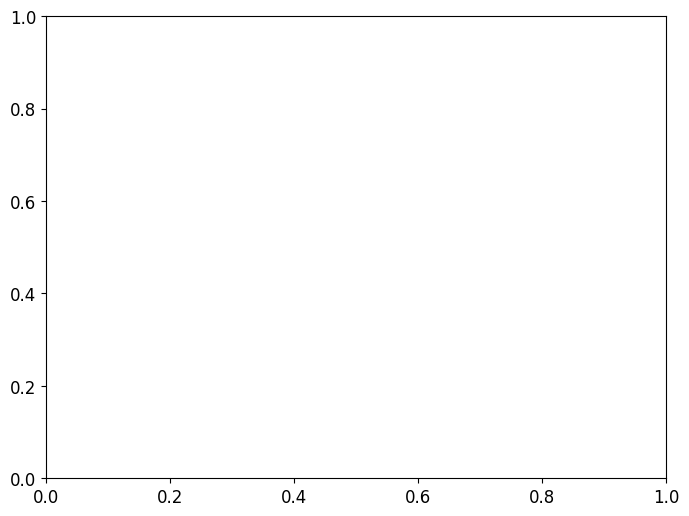

In [249]:
# Step 3: Plot the clusters
if reduce:
    use_data = X_pca[:, :keep_components].copy()
else:
    use_data = data.copy()

fig, ax = plt.subplots(figsize=(8, 6))
cluster_values = kmeans.predict(use_data)


# Plot each cluster with a different color
# scatter = ax.scatter(use_data[:, 0], use_data[:, 1], c=cluster_values, s=100, alpha=.5, cmap=sns.cubehelix_palette(as_cmap=True))#, edgecolor='black',  cmap=sns.cubehelix_palette(as_cmap=True))


In [250]:
# Loop through animals
sessions_to_process = []

for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]

    sessions_to_process.append((mouse_name, session))

In [251]:

if velocity:
    subname = "paw_vel_wavelets_"
else:
    subname = "paw_pos_wavelets_"


In [252]:
data

array([[-0.52337546, -0.48782017, -0.64775588, ..., -0.71652375,
        -0.61960045, -0.49652837],
       [ 0.1228885 ,  0.76484964, -0.04113669, ...,  0.7134855 ,
         1.22824363,  3.13055645],
       [-0.83424835, -0.76362303, -0.65622879, ..., -0.67797557,
        -0.60847906, -0.50275092],
       ...,
       [ 0.78825333,  0.00998207,  0.50607462, ...,  0.59363204,
         0.79343002,  1.5542164 ],
       [-0.41673611, -0.53533368, -0.49991075, ..., -0.13106206,
        -0.48258366, -0.25628324],
       [ 0.80098339,  1.10587225,  0.26085908, ...,  2.1462216 ,
         1.72466907, -0.21498916]], shape=(436000, 20))

/tmp/ipykernel_33877/2367527490.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix['paw_states'][not_nan] = states
/tmp/ipykernel_33877/2367527490.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

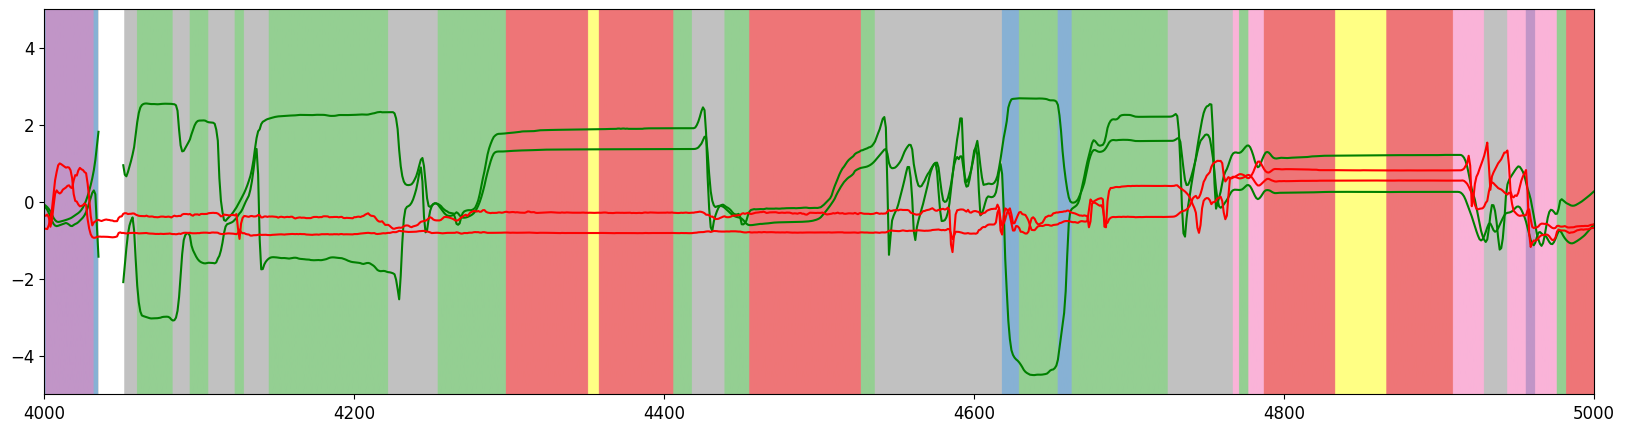

/tmp/ipykernel_33877/2367527490.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix['paw_states'][not_nan] = states
/tmp/ipykernel_33877/2367527490.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

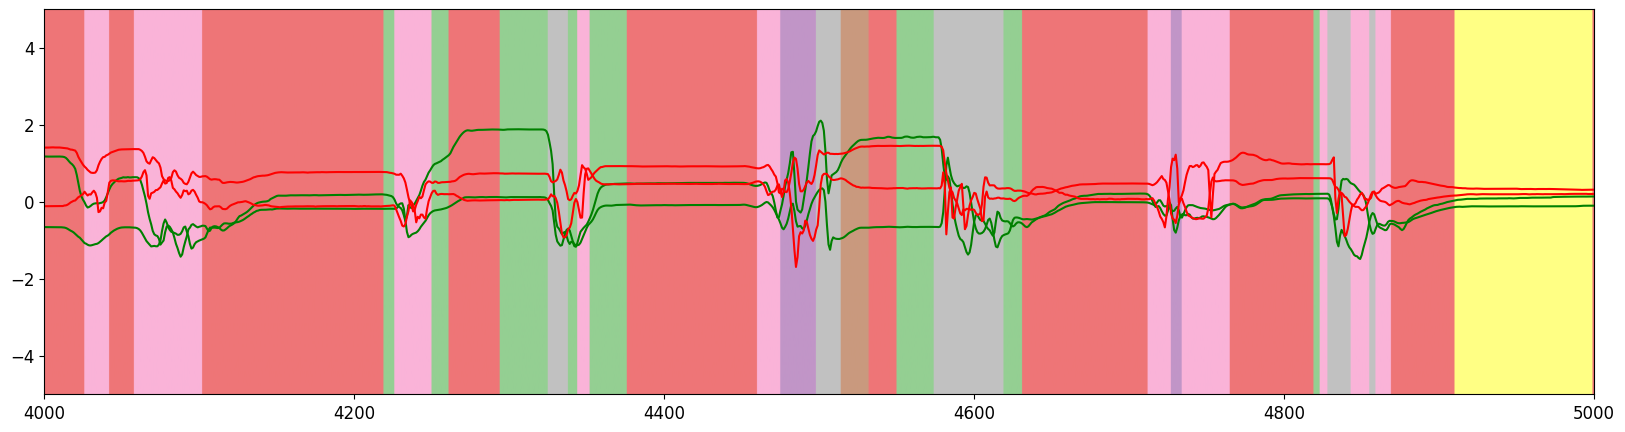

/tmp/ipykernel_33877/2367527490.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix['paw_states'][not_nan] = states
/tmp/ipykernel_33877/2367527490.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

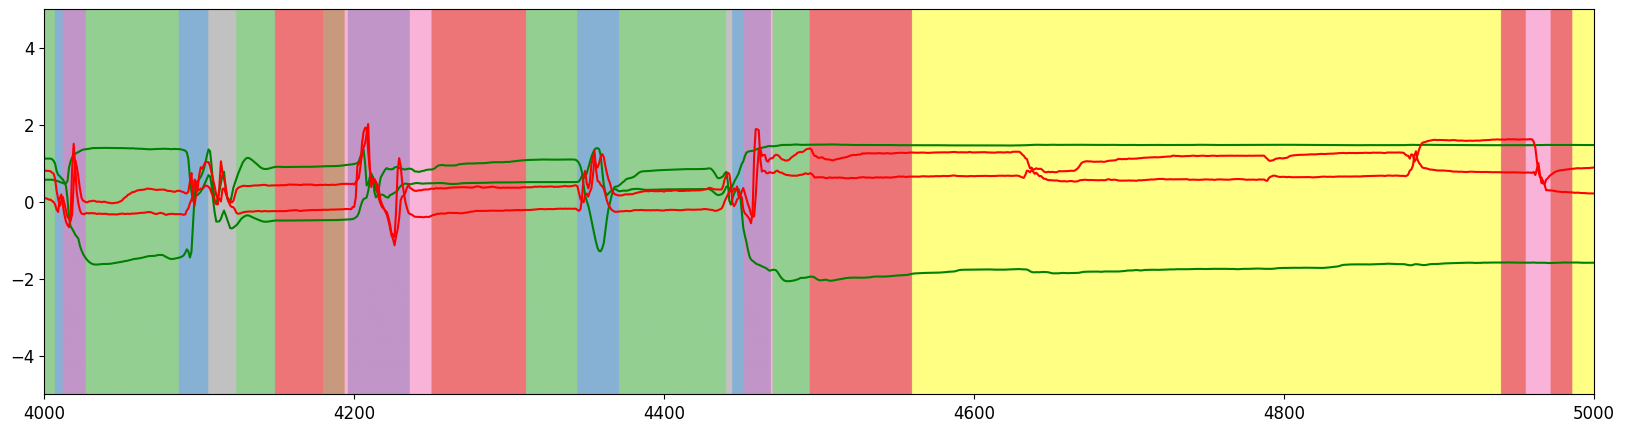

/tmp/ipykernel_33877/2367527490.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix['paw_states'][not_nan] = states
/tmp/ipykernel_33877/2367527490.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

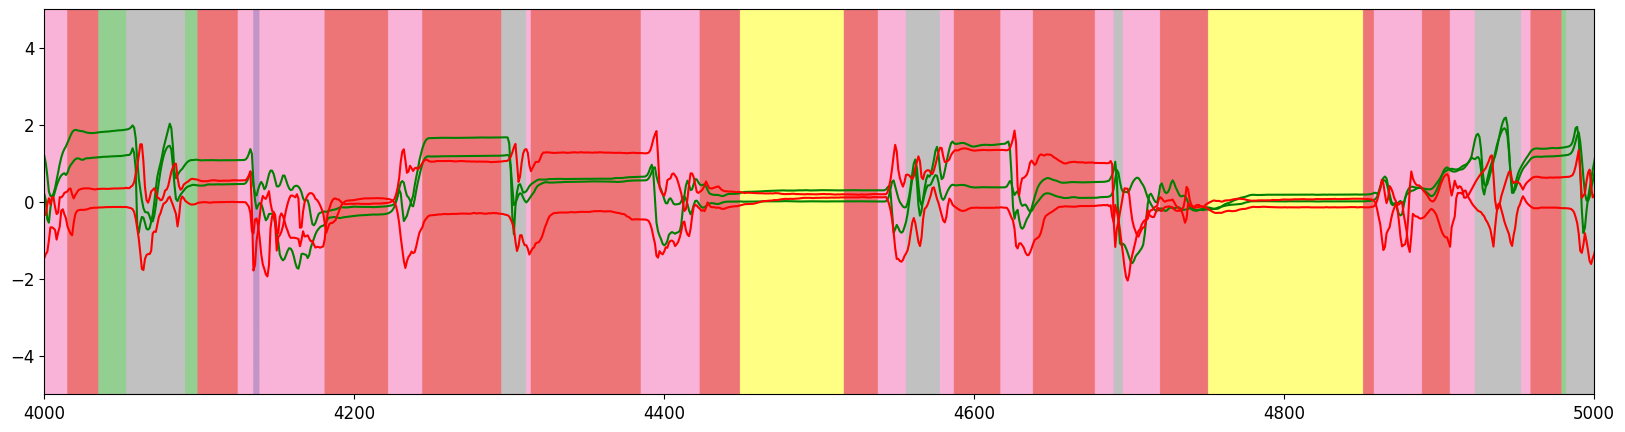

/tmp/ipykernel_33877/2367527490.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix['paw_states'][not_nan] = states
/tmp/ipykernel_33877/2367527490.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

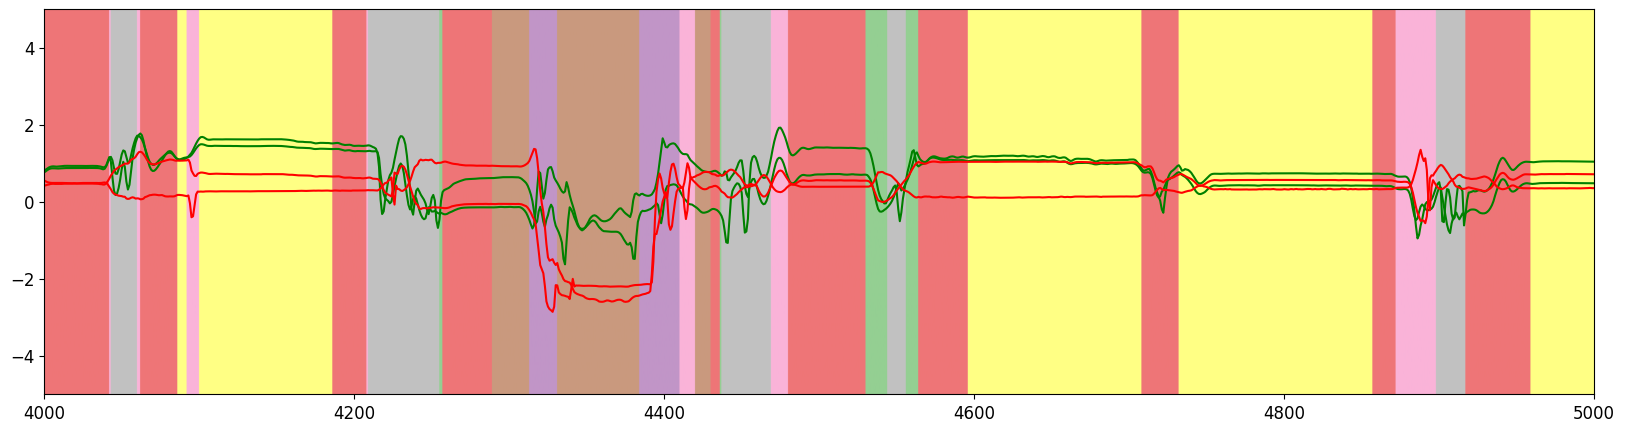

/tmp/ipykernel_33877/2367527490.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix['paw_states'][not_nan] = states
/tmp/ipykernel_33877/2367527490.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

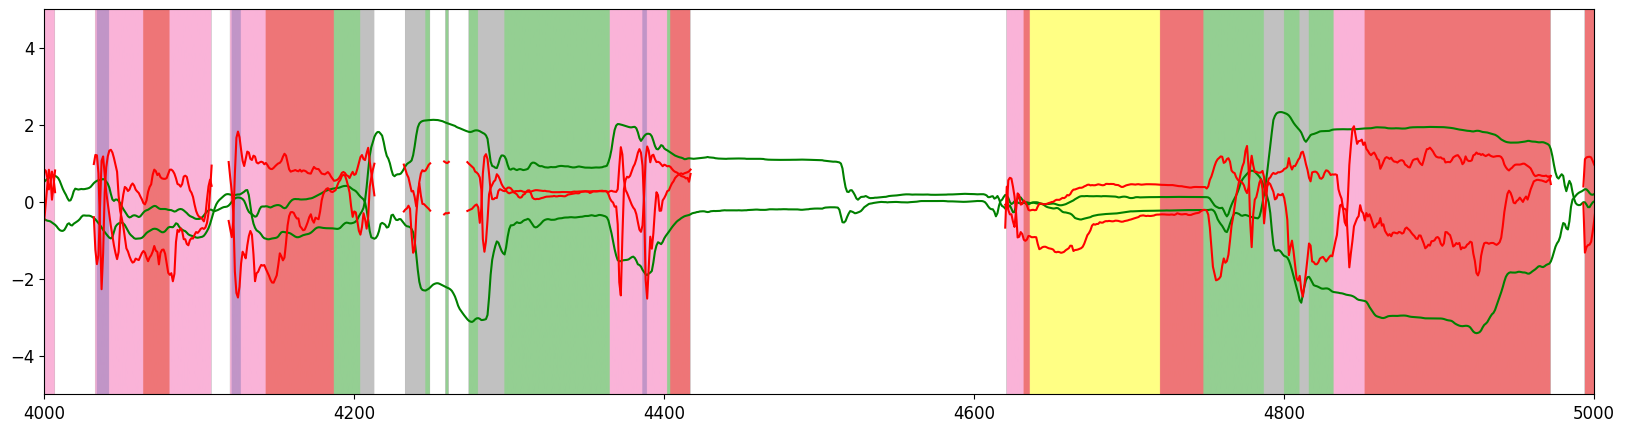

/tmp/ipykernel_33877/2367527490.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix['paw_states'][not_nan] = states
/tmp/ipykernel_33877/2367527490.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

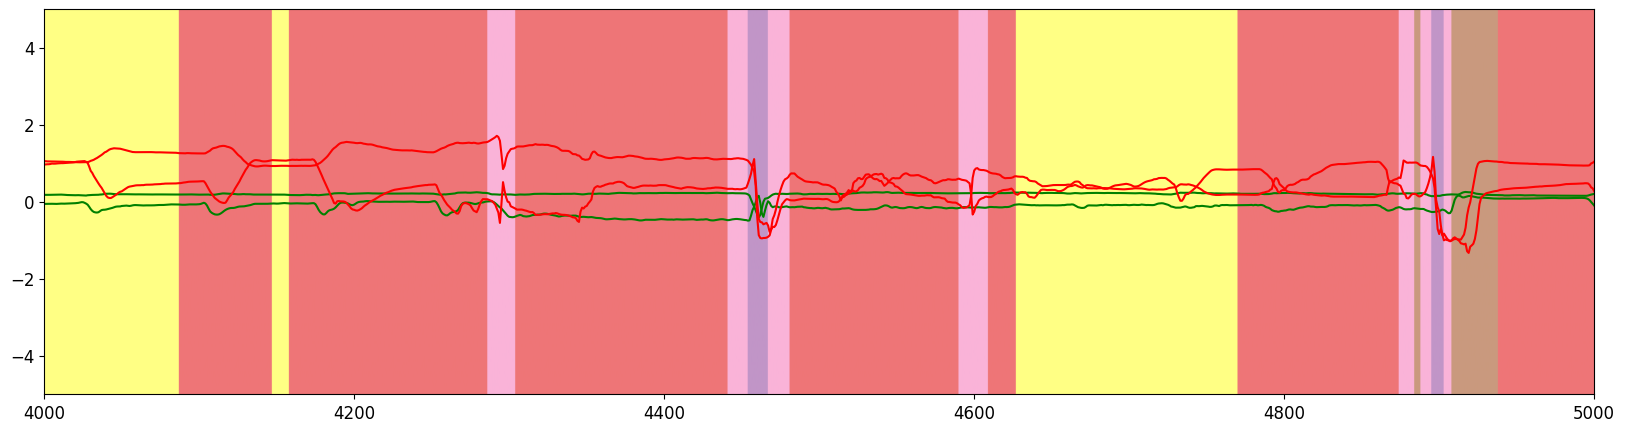

/tmp/ipykernel_33877/2367527490.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix['paw_states'][not_nan] = states
/tmp/ipykernel_33877/2367527490.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

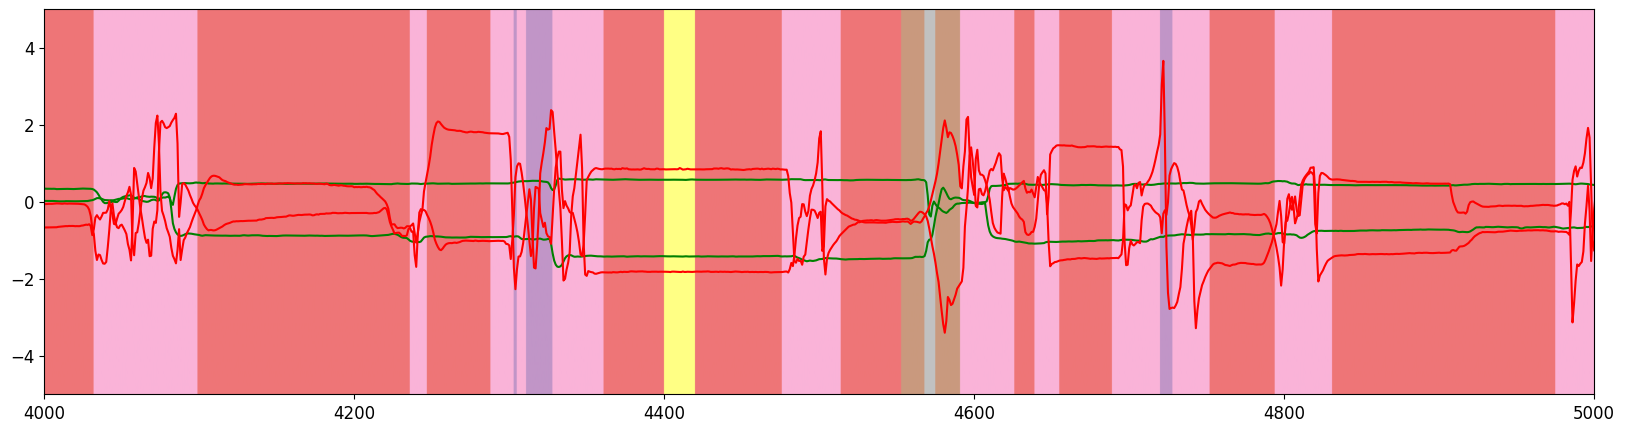

/tmp/ipykernel_33877/2367527490.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix['paw_states'][not_nan] = states
/tmp/ipykernel_33877/2367527490.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

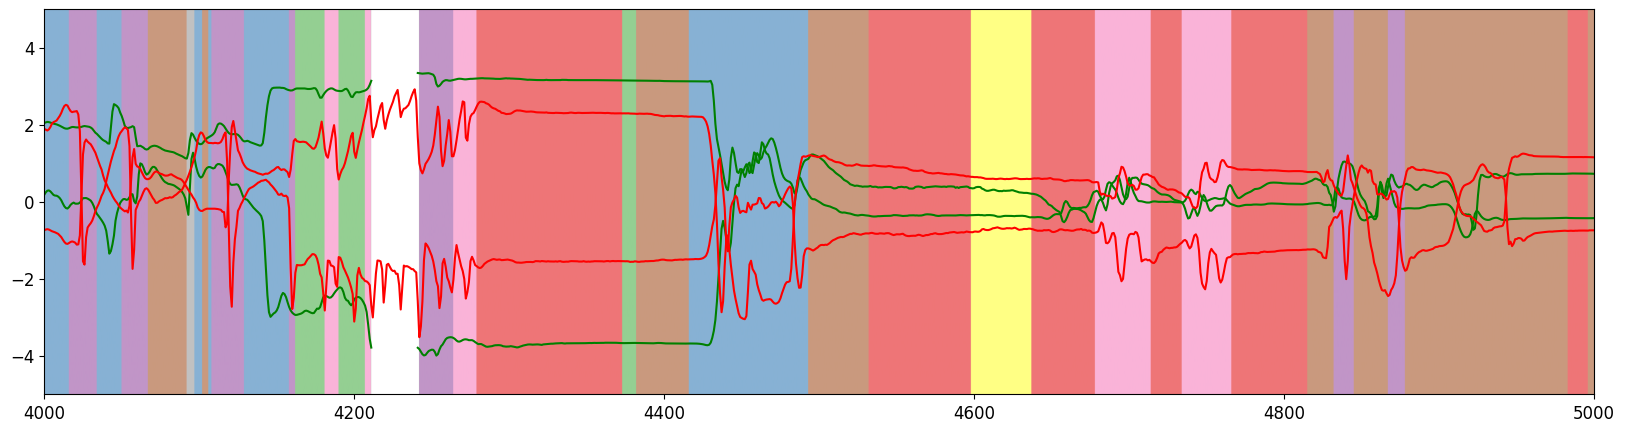

/tmp/ipykernel_33877/2367527490.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix['paw_states'][not_nan] = states
/tmp/ipykernel_33877/2367527490.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

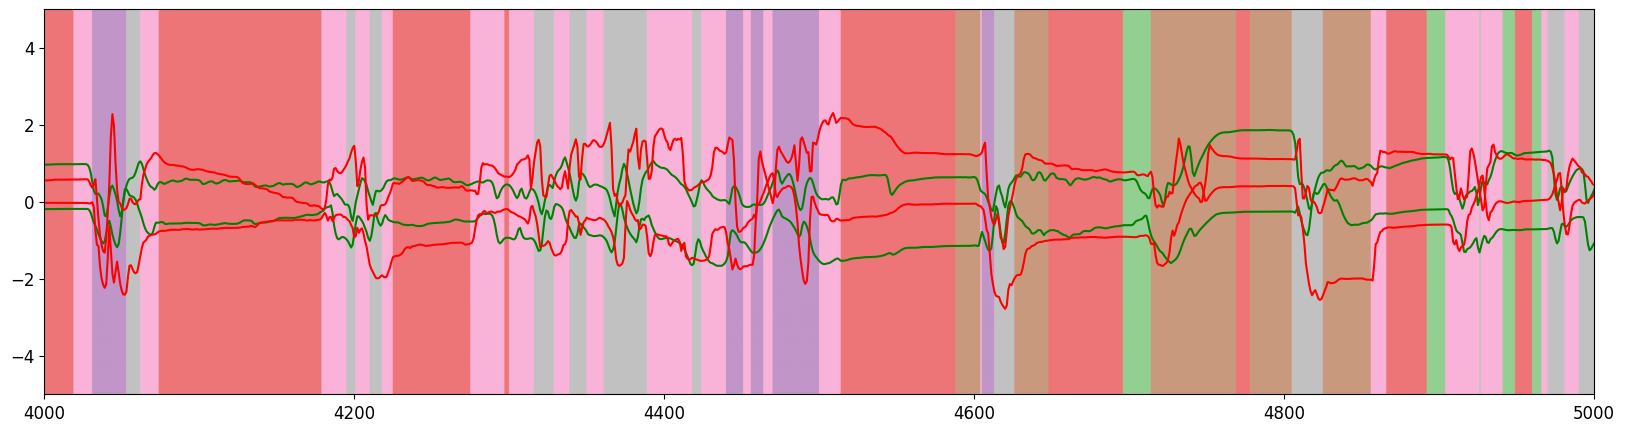

In [253]:
palette = sns.color_palette('Set1', n_colors=optimal_k, as_cmap=True)

assert len(sessions_to_process) == 218
for m, mat in enumerate(sessions_to_process[60:70]):

    mouse_name = mat[0]
    session = mat[1]
    filename = wavelet_path + subname + str(session) + '_'  + mouse_name
    design_matrix = pd.read_parquet(filename)

    # Prepare data
    # data_df = design_matrix[var_interest].copy().dropna()
    # data = np.array(data_df)

    var_array = np.array(design_matrix[use_vars].copy())
    not_nan = ~np.isnan(var_array).any(axis=1)
    mouse_data = stats.zscore(var_array[not_nan, :], axis=0, nan_policy='omit')
        
    """ Compute clusters based on supersession centroids """
    # Compute distances between full dataset and trained centroids
    distances = cdist(mouse_data, centroids, metric='euclidean')
    # Assign each point to the nearest centroid
    states = np.argmin(distances, axis=1)
    
    design_matrix['paw_states'] = np.nan
    design_matrix['paw_states'][not_nan] = states
    
    fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 5])
    plt.rc('font', size=12)
    init = 000
    # ax.plot(design_matrix.loc[design_matrix['Bin']>=init, 'avg_wheel_vel'].reset_index(), color='black')
    ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_x'].reset_index()['l_paw_x'], nan_policy='omit'), color='green')
    ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_y'].reset_index()['l_paw_y'], nan_policy='omit'), color='green')
    ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'r_paw_x'].reset_index()['r_paw_x'], nan_policy='omit'), color='red')
    ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'r_paw_y'].reset_index()['r_paw_y'], nan_policy='omit'), color='red')
    attach_array = np.arange(0, optimal_k, 1)
    ax.imshow(np.concatenate([design_matrix.loc[design_matrix['Bin']>=init, 'paw_states']])[None,:],
                extent=(0, len(np.concatenate([design_matrix.loc[design_matrix['Bin']>=init, 'paw_states']])), -10, 10),
                aspect="auto",
                alpha=0.6,
                cmap=palette)  # 
    init=4000
    plt.xlim([init, init+1000])
    plt.ylim([-5, 5])
    plt.show()
    # plt.hist(states)
    # plt.show()

In [254]:
all_data = pd.DataFrame(use_data, columns=use_vars)
all_data['paw_states'] = kmeans.predict(use_data)
wavelet_df = pd.melt(all_data, id_vars=['paw_states'], value_vars=use_vars)

In [90]:
use_data = design_matrix.copy()
wavelet_vars = ['l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 
                'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 
                'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0',
                'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0']

paw_vars = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y']
paw_df = pd.melt(use_data, id_vars=['paw_states'], value_vars=paw_vars)

wavelet_df = pd.melt(use_data, id_vars=['paw_states'], value_vars=wavelet_vars)

<Axes: xlabel='paw_states', ylabel='value'>

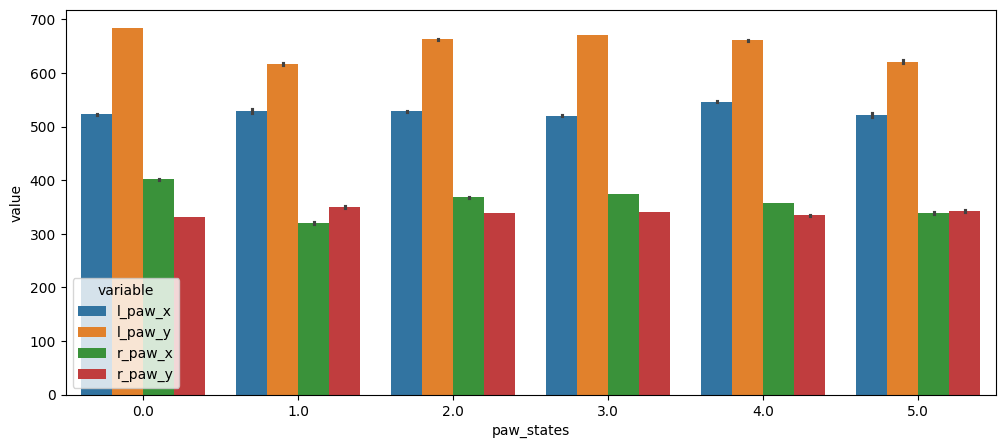

In [91]:
plt.figure(figsize=[12, 5])
sns.barplot(x='paw_states', y='value', hue='variable', data=paw_df)

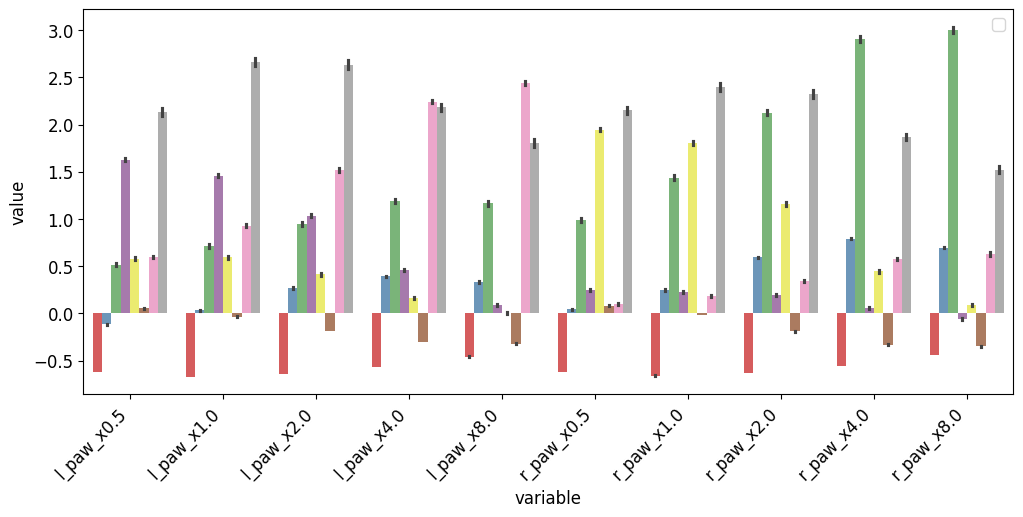

In [219]:

x_labels = ['l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0',
       'l_paw_x8.0', 'r_paw_x0.5', 'r_paw_x1.0',
       'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0']
y_labels = ['l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0',
       'l_paw_y4.0', 'l_paw_y8.0',  'r_paw_y0.5',
       'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0']
plt.figure(figsize=[12, 5])
sns.barplot(hue='paw_states', y='value', x='variable', data=wavelet_df.loc[wavelet_df['variable'].isin(x_labels)], palette=palette, alpha=.8)
plt.xticks(rotation=45, ha='right')
plt.legend('')
plt.show()

# plt.figure(figsize=[12, 5])
# sns.barplot(hue='paw_states', y='value', x='variable', data=wavelet_df.loc[wavelet_df['variable'].isin(y_labels)], palette=palette, alpha=.8)
# plt.xticks(rotation=45, ha='right')
# plt.legend('')
# plt.show()


In [184]:
palette = sns.color_palette('Set1', n_colors=optimal_k, as_cmap=True)

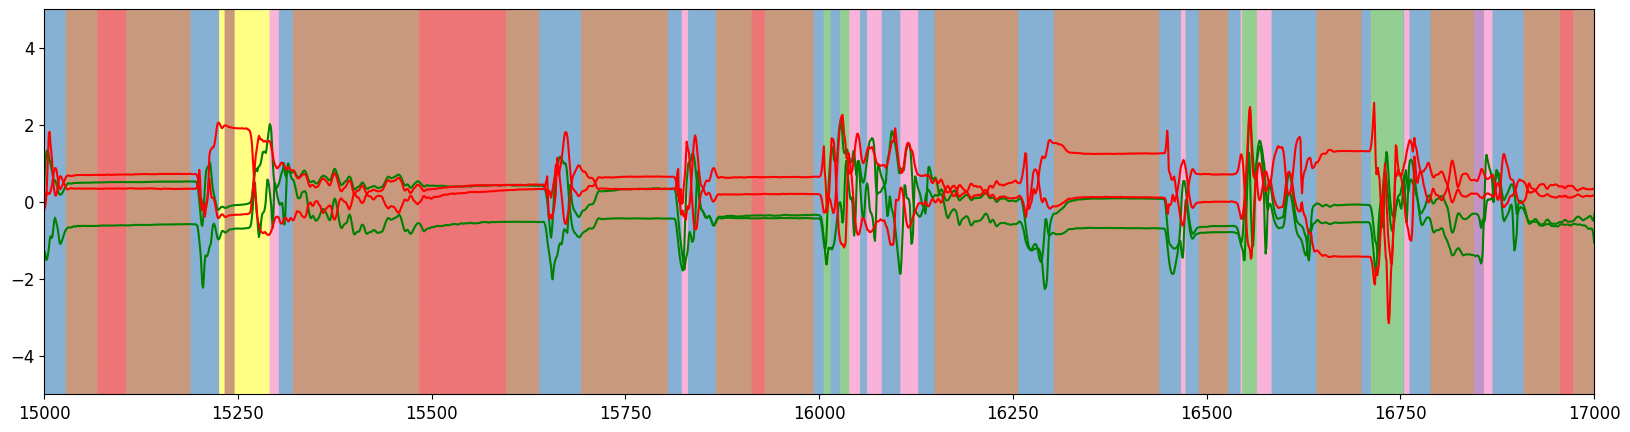

In [185]:

fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 5])
plt.rc('font', size=12)
init = 000
# ax.plot(design_matrix.loc[design_matrix['Bin']>=init, 'avg_wheel_vel'].reset_index(), color='black')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_x'].reset_index()['l_paw_x'], nan_policy='omit'), color='green')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_y'].reset_index()['l_paw_y'], nan_policy='omit'), color='green')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'r_paw_x'].reset_index()['r_paw_x'], nan_policy='omit'), color='red')
ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'r_paw_y'].reset_index()['r_paw_y'], nan_policy='omit'), color='red')
attach_array = np.arange(0, optimal_k, 1)
ax.imshow(np.concatenate([design_matrix.loc[design_matrix['Bin']>=init, 'paw_states']])[None,:],
            extent=(0, len(np.concatenate([design_matrix.loc[design_matrix['Bin']>=init, 'paw_states']])), -10, 10),
            aspect="auto",
            alpha=0.6,
            cmap=palette)  # 
init=15000
plt.xlim([init, init+2000])
plt.ylim([-5, 5])
plt.show()

(array([212213.,      0.,   3139.,      0.,  18218.,      0.,  33313.,
             0.,  10910.,   3470.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

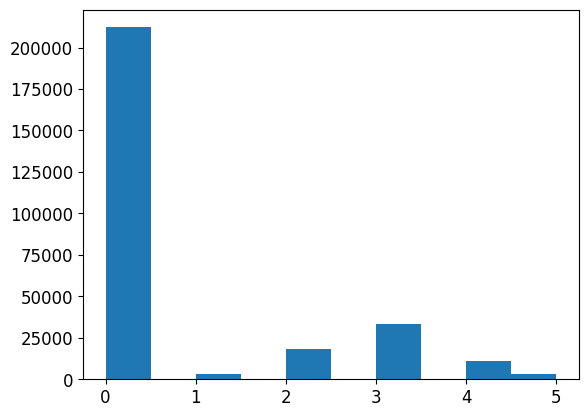

In [95]:
plt.hist(states)